# **Tutorial** - Time Series Prediction of Snow Water Equivalent (SWE) Using LSTM in PyTorch - Now Using UA SWE Data 


This notebook is a slightly modified version of the protoype model provided to the Frosty Dawgs team, demonstrating an LSTM model to predict SWE on several Huc10 units in Skagit Basin.  It represents the starting point for the team's work and we thank the authors of the original prototype model.  

This notebook modifies the original noebook by chainging the data source to use a longer time series of data (UA data).  Additional modifications include: (1) adds a KGE goodness of fit metric, (2) adds ML Flow tracking capabilities and (3) normalizes the UA data prior to model training. 

First, we import all the necessary libraries such as `torch`, `numpy`, `pandas`, and others for data preprocessing, model building, and evaluation. These libraries are key for handling data, neural networks, and visualization.

In [1]:
import os
import time
import gdown
import torch
import warnings
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.utils.data as data
from snowML import data_utils as du

from torch import nn
#from tqdm.autonotebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

warnings.filterwarnings('ignore')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float32

##  Set the MLflow tracking server

Note: Assumes you have already started mlflow by opening a terminal withy mlflow installed and running mlflow uo

In [2]:
# Set our tracking server uri for logging
tracking_uri = "arn:aws:sagemaker:us-west-2:677276086662:mlflow-tracking-server/dawgsML"
mlflow.set_tracking_uri(tracking_uri)

# Create a new MLflow Experiment called "LSTM"
mlflow.set_experiment("ProtoType_Results")

<Experiment: artifact_location='s3://sues-test/199', creation_time=1740199897768, experiment_id='199', last_update_time=1740199897768, lifecycle_stage='active', name='ProtoType_Results', tags={}>

## Data Prepration 

In [3]:
# This function loads the model ready data for a given huc number

def get_dogs_data(huc_list, var_list):
    bucket_name = "snowml-model-ready"
    df_dict = {}  # Initialize dictionary
    for huc in huc_list: 
        file_name = f"model_ready_huc{huc}.csv"
        df = du.s3_to_df(file_name, bucket_name)
        df['day'] = pd.to_datetime(df['day'])
        df.set_index('day', inplace=True)  # Set 'day' as the index
        df = df[var_list]
        df_dict[huc] = df  # Store DataFrame in dictionary
    return df_dict


In [4]:
huc_list = [1711000504, 1711000505, 1711000506, 1711000507, 1711000508, 1711000509, 1711000511]
var_list = ["mean_pr", "mean_tair", "mean_swe"]
df_dict = get_dogs_data(huc_list, var_list)
# display an example 
df = df_dict[1711000506]
df.head(2)

,mean_pr,mean_tair,mean_swe
day,,,
1983-10-01,0.0,4.683,0.0
1983-10-02,0.0,5.416,0.0


In [5]:
# This function normalizes the data using the Z-score formula, which helps to standardize the features

def z_score_normalize(df):
    normalized_df = df.copy()

    for column in ["mean_pr", "mean_tair"]:
        column_mean = df[column].mean()
        column_std = df[column].std()
        normalized_df[column] = (df[column] - column_mean) / column_std

    return normalized_df

## **Creating Dataset for Time Series Prediction**

This function transforms time-series data into a format suitable for model training. It uses the lookback parameter to determine how many previous time steps to consider as input features

In [6]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A pandas DataFrame of time series data
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset.iloc[i:(i + lookback), :2].values  # Select first two columns
        target = dataset.iloc[i + lookback, -1:].values  # Selects the last column dynamically
        X.append(feature)
        y.append(target)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [7]:
def train_test_split(data, train_size_fraction):
    train_size_main = int(len(data) * train_size_fraction)
    test_size_main = len(data) - train_size_main
    train_main, test_main = data[:train_size_main], data[train_size_main:]
    return train_main, test_main, train_size_main, test_size_main

## **Snow Model (LSTM Neural Network)**

This is a simple LSTM-based neural network model designed for predicting mean_swe values. The model uses one LSTM layer followed by a linear layer and LeakyReLU activation.



In [8]:
class SnowModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_class, num_layers, dropout):
        super(SnowModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, dropout=self.dropout, batch_first=True)
        self.linear = nn.Linear(hidden_size, num_class)
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        device = x.device
        hidden_states = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        cell_states = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm1(x, (hidden_states, cell_states))
        out = self.linear(out[:, -1, :])
        out = self.leaky_relu(out)
        return out

## **Training the Model**

This function trains the model on the training data for a specified number of epochs and batch size. It also prints the Root Mean Square Error (RMSE) every 10 epochs.

In [9]:
def train_model(model, optimizer, loss_fn, X_train, y_train, n_epochs, batch_size):
	loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)
	epoch_losses = []

	for epoch in  range(n_epochs):
		epoch_loss = 0.0
		model.train()
		for X_batch, y_batch in loader:
			y_pred = model(X_batch)
			loss = loss_fn(y_pred, y_batch)
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
			epoch_loss += loss.item()
		# Validation
		if epoch % 10 != 0:
			continue

		model.eval()

		with torch.no_grad():
			y_pred = model(X_train)
			train_rmse = np.sqrt(loss_fn(y_pred, y_train))
			print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}")

		epoch_losses.append(epoch_loss / len(loader))

	return epoch_losses

## **Predicting and Plotting Results**

This function predicts values on the training and test datasets and visualizes the predictions compared to the actual mean_swe values.



In [10]:
def predict(data, model, X_train,X_test, lookback, train_size, huc_no):
    data = data.astype(object)
    with torch.no_grad():
        train_plot = np.full_like(data['mean_swe'].values, np.nan, dtype=float)
        y_pred = model(X_train)
        print(y_pred.shape)
        y_pred_new = y_pred[:,  -1].unsqueeze(1)
        print(y_pred_new.shape)
        print(type(lookback),type(train_size))
        train_plot[lookback:train_size] = y_pred_new.numpy().flatten()

        # shift test predictions for plotting
        test_plot = np.full_like(data['mean_swe'].values, np.nan, dtype=float)
        test_plot[train_size+lookback:len(data)] = model(X_test)[:,  -1].unsqueeze(1).numpy().flatten()

    # plot
    fig, ax = plt.subplots(figsize=(12, 6))  # Create figure explicitly
    ax.plot(data.index, data['mean_swe'], c='b', label='Actual')
    ax.plot(data.index, train_plot, c='r', label='Train Predictions')
    ax.plot(data.index[train_size+lookback:], test_plot[train_size+lookback:], c='g', label='Test Predictions')
    ax.legend()
    ax.set_xlabel('Date')
    ax.set_ylabel('mean_swe')
    ttl = f"UAData_SWE_Post_Predictions_for_huc_{huc_no}"
    ax.set_title(ttl)
    plt.show()

    fig.savefig(f"{ttl}.png", bbox_inches='tight')
    mlflow.log_artifact(f"{ttl}.png")
    plt.close(fig)

## **Model Evaluation**
This function evaluates the model using standard metrics such as Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared score (R2). In addition, Kling-gupta-efficiency (KGE) added by the Frosty Dawgs team. 

In [11]:
def kling_gupta_efficiency(y_true, y_pred):
    r = np.corrcoef(y_true.ravel(), y_pred.ravel())[0, 1] # Correlation coefficient
    alpha = np.std(y_pred) / np.std(y_true)  # Variability ratio
    beta = np.mean(y_pred) / np.mean(y_true)  # Bias ratio
    kge = 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)
    #print(f"r: {r}, alpha: {alpha}, beta: {beta}")
    return kge

In [12]:
def evaluate_metrics(model, X_train, y_train, X_test, y_test):
    with torch.no_grad():
        y_train_pred = model(X_train)
        y_test_pred = model(X_test)

    train_mse = mean_squared_error(y_train.numpy(), y_train_pred.numpy())
    test_mse = mean_squared_error(y_test.numpy(), y_test_pred.numpy())
    train_mae = mean_absolute_error(y_train.numpy(), y_train_pred.numpy())
    test_mae = mean_absolute_error(y_test.numpy(), y_test_pred.numpy())
    train_r2 = r2_score(y_train.numpy(), y_train_pred.numpy())
    test_r2 = r2_score(y_test.numpy(), y_test_pred.numpy())

    test_kge = kling_gupta_efficiency(y_test.numpy(), y_test_pred.numpy())  # Fixed function call
    train_kge = kling_gupta_efficiency(y_train.numpy(), y_train_pred.numpy())  # Fixed variable name

    return [train_mse, test_mse, train_mae, test_mae, train_r2, test_r2, train_kge, test_kge]


In [13]:
def  get_csv_filenames(directory):
  """ Returns a sorted list of CSV filenames from the given directory."""
  return  sorted([f for f in os.listdir(directory)  if f.endswith('.csv')])

## **Running the Pipeline**

This section retrieves the filenames from the dataset directories, filters and merges data, and finally trains and evaluates the model.

NA datais mean_pr      0
mean_tair    0
mean_swe     0
dtype: int64

Lookback: 180
Epoch 0: train RMSE 0.1132
torch.Size([9363, 1])
torch.Size([9363, 1])
<class 'int'> <class 'int'>


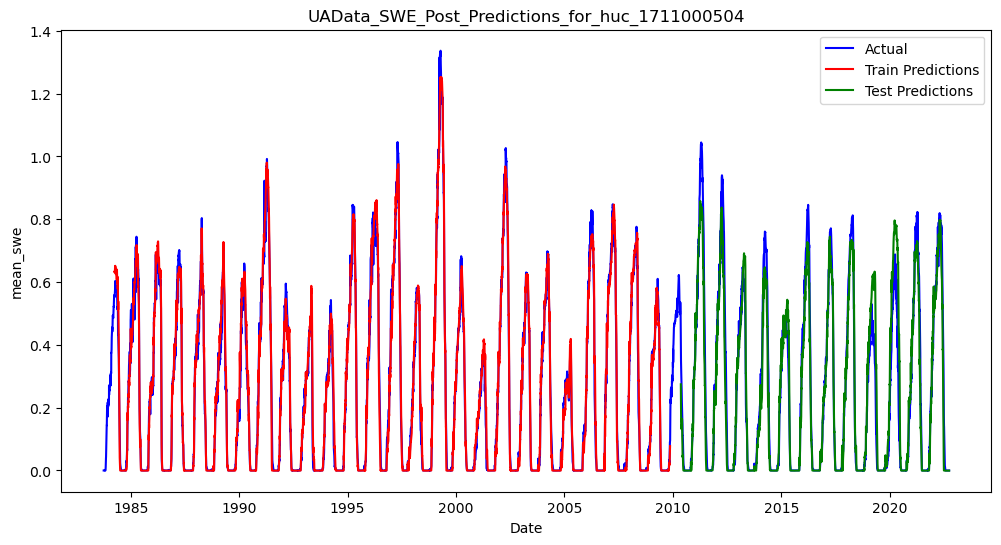

[0.0011515233, 0.0054084584, 0.021952726, 0.043805268, 0.9853174090385437, 0.9319043159484863, 0.9852520428345745, 0.9388823919210325]
metric name is: 1711000504_train_mse
metric is: 0.001151523320004344
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180  snotel  train_mse  0.001152      110.374198
1       180  snotel   test_mse  0.005408      110.374198
2       180  snotel  train_mae  0.021953      110.374198
3       180  snotel   test_mae  0.043805      110.374198
4       180  snotel   train_r2  0.985317      110.374198
5       180  snotel    test_r2  0.931904      110.374198
6       180  snotel  train_kge  0.985252      110.374198
7       180  snotel   test_kge  0.938882      110.374198
NA datais mean_pr      0
mean_tair    0
mean_swe     0
dtype: int64

Lookback: 180
Epoch 0: train RMSE 0.0489
torch.Size([9363, 1])
torch.Size([9363, 1])
<class 'int'> <class 'int'>


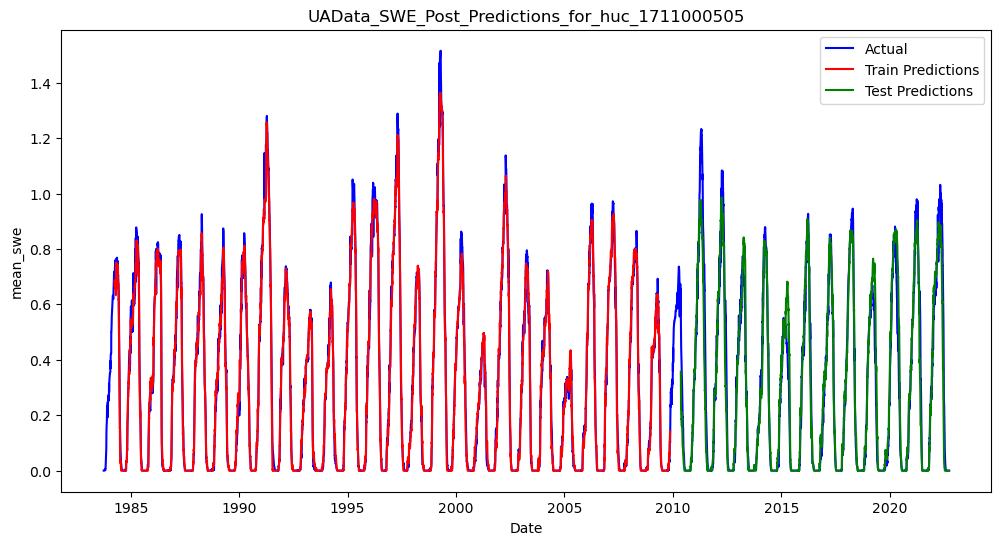

[0.0008700346, 0.0057569933, 0.01937409, 0.043201055, 0.9922515153884888, 0.9451746344566345, 0.970156043667427, 0.9550740609869187]
metric name is: 1711000505_train_mse
metric is: 0.0008700346224941313
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180  snotel  train_mse  0.000870      103.276188
1       180  snotel   test_mse  0.005757      103.276188
2       180  snotel  train_mae  0.019374      103.276188
3       180  snotel   test_mae  0.043201      103.276188
4       180  snotel   train_r2  0.992252      103.276188
5       180  snotel    test_r2  0.945175      103.276188
6       180  snotel  train_kge  0.970156      103.276188
7       180  snotel   test_kge  0.955074      103.276188
NA datais mean_pr      0
mean_tair    0
mean_swe     0
dtype: int64

Lookback: 180
Epoch 0: train RMSE 0.0461
torch.Size([9363, 1])
torch.Size([9363, 1])
<class 'int'> <class 'int'>


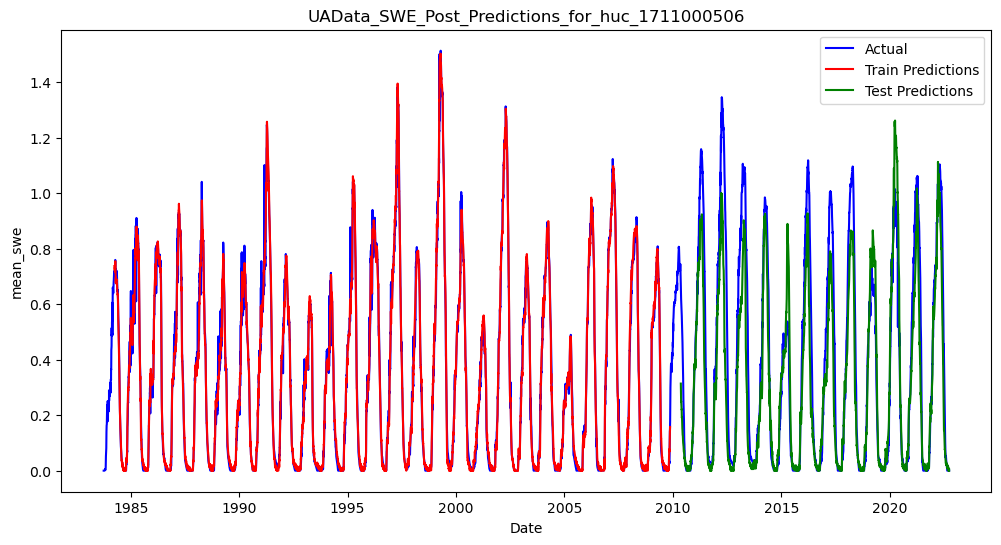

[0.0008939414, 0.025918376, 0.020279821, 0.10621434, 0.9921125173568726, 0.8202931880950928, 0.989833502182413, 0.7594024828741779]
metric name is: 1711000506_train_mse
metric is: 0.0008939413819462061
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180  snotel  train_mse  0.000894      103.581779
1       180  snotel   test_mse  0.025918      103.581779
2       180  snotel  train_mae  0.020280      103.581779
3       180  snotel   test_mae  0.106214      103.581779
4       180  snotel   train_r2  0.992113      103.581779
5       180  snotel    test_r2  0.820293      103.581779
6       180  snotel  train_kge  0.989834      103.581779
7       180  snotel   test_kge  0.759402      103.581779
NA datais mean_pr      0
mean_tair    0
mean_swe     0
dtype: int64

Lookback: 180
Epoch 0: train RMSE 0.0339
torch.Size([9363, 1])
torch.Size([9363, 1])
<class 'int'> <class 'int'>


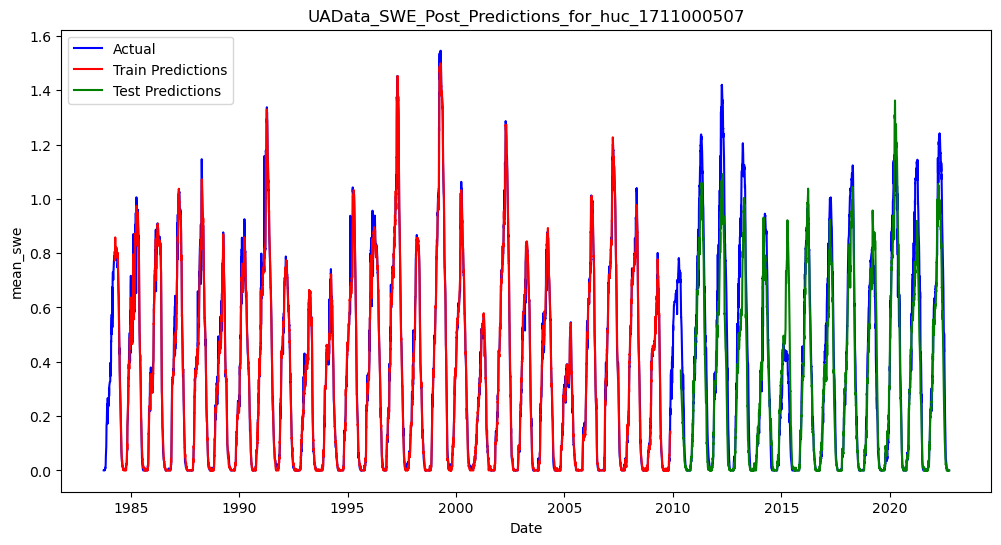

[0.0005388836, 0.018348182, 0.01458341, 0.08763361, 0.9954832196235657, 0.8778650164604187, 0.9888781380869103, 0.8104590162576535]
metric name is: 1711000507_train_mse
metric is: 0.0005388836143538356
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180  snotel  train_mse  0.000539      110.255708
1       180  snotel   test_mse  0.018348      110.255708
2       180  snotel  train_mae  0.014583      110.255708
3       180  snotel   test_mae  0.087634      110.255708
4       180  snotel   train_r2  0.995483      110.255708
5       180  snotel    test_r2  0.877865      110.255708
6       180  snotel  train_kge  0.988878      110.255708
7       180  snotel   test_kge  0.810459      110.255708
NA datais mean_pr      0
mean_tair    0
mean_swe     0
dtype: int64

Lookback: 180
Epoch 0: train RMSE 0.0225
torch.Size([9363, 1])
torch.Size([9363, 1])
<class 'int'> <class 'int'>


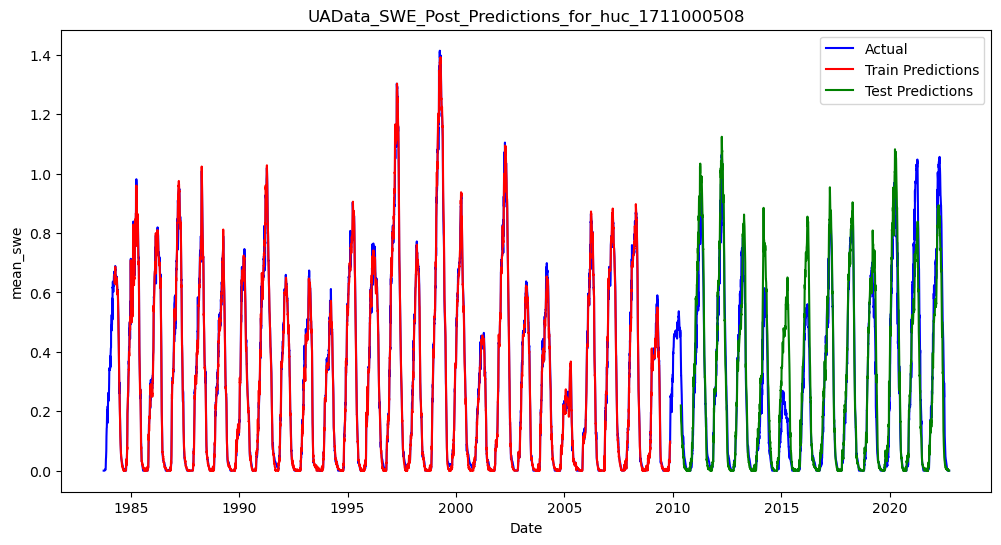

[0.00031196757, 0.010092936, 0.01184305, 0.062260363, 0.9967027306556702, 0.8884763717651367, 0.988234700595943, 0.9007188497055202]
metric name is: 1711000508_train_mse
metric is: 0.0003119675675407052
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180  snotel  train_mse  0.000312      107.993167
1       180  snotel   test_mse  0.010093      107.993167
2       180  snotel  train_mae  0.011843      107.993167
3       180  snotel   test_mae  0.062260      107.993167
4       180  snotel   train_r2  0.996703      107.993167
5       180  snotel    test_r2  0.888476      107.993167
6       180  snotel  train_kge  0.988235      107.993167
7       180  snotel   test_kge  0.900719      107.993167
NA datais mean_pr      0
mean_tair    0
mean_swe     0
dtype: int64

Lookback: 180
Epoch 0: train RMSE 0.0231
torch.Size([9363, 1])
torch.Size([9363, 1])
<class 'int'> <class 'int'>


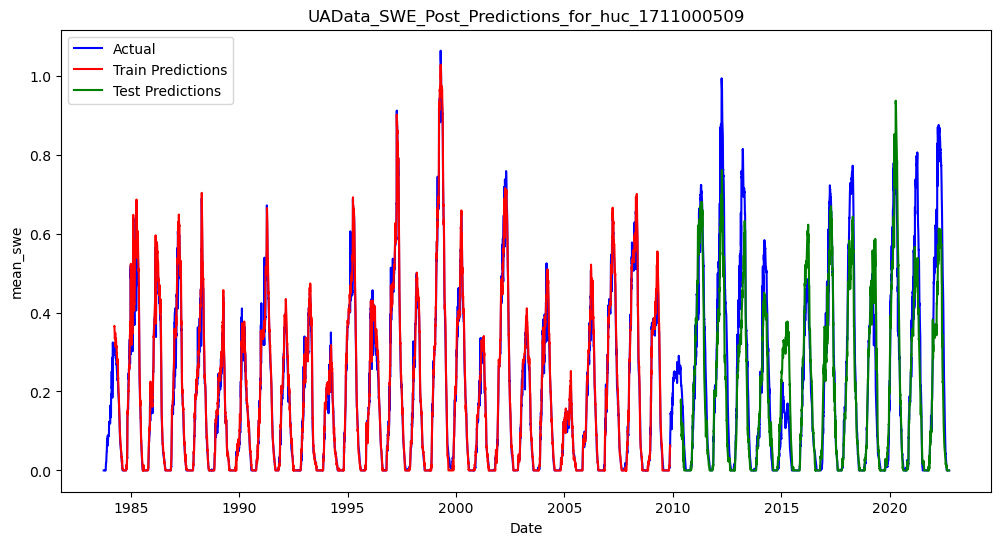

[0.0004471654, 0.010214329, 0.01343952, 0.06477149, 0.9883838891983032, 0.8406068086624146, 0.9424873234191816, 0.7950272232438419]
metric name is: 1711000509_train_mse
metric is: 0.0004471653955988586
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180  snotel  train_mse  0.000447      101.198706
1       180  snotel   test_mse  0.010214      101.198706
2       180  snotel  train_mae  0.013440      101.198706
3       180  snotel   test_mae  0.064771      101.198706
4       180  snotel   train_r2  0.988384      101.198706
5       180  snotel    test_r2  0.840607      101.198706
6       180  snotel  train_kge  0.942487      101.198706
7       180  snotel   test_kge  0.795027      101.198706
NA datais mean_pr      0
mean_tair    0
mean_swe     0
dtype: int64

Lookback: 180
Epoch 0: train RMSE 0.0139
torch.Size([9363, 1])
torch.Size([9363, 1])
<class 'int'> <class 'int'>


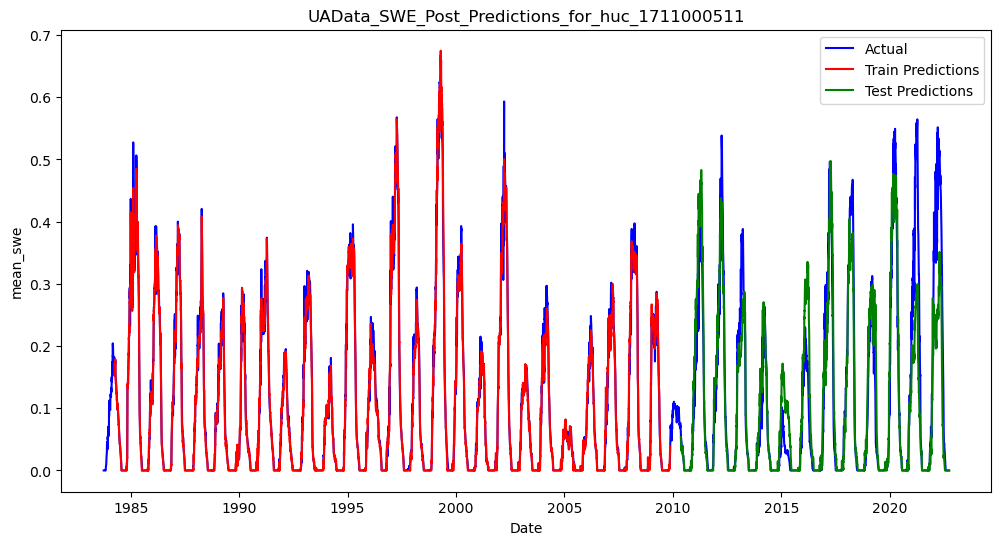

[0.000120895915, 0.0038778768, 0.006322636, 0.035116546, 0.9927427172660828, 0.8292859196662903, 0.9890757744520565, 0.8484269077025433]
metric name is: 1711000511_train_mse
metric is: 0.00012089591473340988
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180  snotel  train_mse  0.000121      104.259274
1       180  snotel   test_mse  0.003878      104.259274
2       180  snotel  train_mae  0.006323      104.259274
3       180  snotel   test_mae  0.035117      104.259274
4       180  snotel   train_r2  0.992743      104.259274
5       180  snotel    test_r2  0.829286      104.259274
6       180  snotel  train_kge  0.989076      104.259274
7       180  snotel   test_kge  0.848427      104.259274
🏃 View run bittersweet-bug-588 at: https://us-west-2.experiments.sagemaker.aws/#/experiments/199/runs/f0bde540d8184f7e8ea057456ec56f38
🧪 View experiment at: https://us-west-2.experiments.sagemaker.aws/#/experiments/199


In [14]:
# Define the hyperparameters
input_size=2
hidden_size=2**6
num_class=1
num_layers=1
dropout = 0.5

learning_rate = 1e-3 #3e-3
n_epochs = 10
train_size_fraction = 0.67
lookback_values =  [180]


with mlflow.start_run():
    # log all the params
    mlflow.log_param("Training From", "Prototype Notebook")
    mlflow.log_param("Data Source", "UA SWE Data")
    mlflow.log_param("input_size", input_size)
    mlflow.log_param("hidden_size", hidden_size)
    mlflow.log_param("num_class", num_class)
    mlflow.log_param("num_layers", num_layers)
    mlflow.log_param("dropout", dropout)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("train_size_fraction", train_size_fraction)
    mlflow.log_param("lookback_values", lookback_values)
    mlflow.log_param("epochs", n_epochs) 

    model_snotel = SnowModel(input_size, hidden_size, num_class, num_layers, dropout)
    optimizer_snotel = optim.Adam(model_snotel.parameters())
    loss_fn_snotel = nn.MSELoss()

    for huc_no in huc_list: 
        # Get the model ready data 
        data = df_dict[(huc_no)]
        data = z_score_normalize(data)
        print(f"NA datais {data.isna().sum()}")
        data = data.fillna(method='bfill')
        train_main, test_main, train_size_main, test_size_main = train_test_split(data, train_size_fraction)

        # Usage example
        lookback_values =  [180]
        results = []

        for lookback in lookback_values:
            print(f"\nLookback: {lookback}")
            start_time = time.time()

            # Snotel dataset
            X_train_snotel, y_train_snotel = create_dataset(train_main, lookback)
            X_test_snotel, y_test_snotel = create_dataset(test_main, lookback)

            train_model(model_snotel, optimizer_snotel, loss_fn_snotel, X_train_snotel, y_train_snotel, n_epochs=n_epochs, batch_size=8) 
            predict(data,model_snotel,  X_train_snotel,X_test_snotel, lookback, train_size_main, huc_no)
            snotel_metrics = evaluate_metrics(model_snotel, X_train_snotel, y_train_snotel, X_test_snotel, y_test_snotel)
            print(snotel_metrics)
            elapsed_time = time.time() - start_time

            results.append([lookback, 'snotel', 'train_mse', snotel_metrics[0], elapsed_time])
            results.append([lookback, 'snotel', 'test_mse', snotel_metrics[1], elapsed_time])
            results.append([lookback, 'snotel', 'train_mae', snotel_metrics[2], elapsed_time])
            results.append([lookback, 'snotel', 'test_mae', snotel_metrics[3], elapsed_time])
            results.append([lookback, 'snotel', 'train_r2', snotel_metrics[4], elapsed_time])
            results.append([lookback, 'snotel', 'test_r2', snotel_metrics[5], elapsed_time])
            results.append([lookback, 'snotel', 'train_kge', snotel_metrics[6], elapsed_time])
            results.append([lookback, 'snotel', 'test_kge', snotel_metrics[7], elapsed_time])

            
            mlflow.log_metric(f"{huc_no}_train_mse", snotel_metrics[0])
            mlflow.log_metric(f"{huc_no}_test_mse", snotel_metrics[1])
            mlflow.log_metric(f"{huc_no}_train_kge", snotel_metrics[6])
            mlflow.log_metric(f"{huc_no}_test_kge", snotel_metrics[7])

        


        # Create a DataFrame for the results
        df_results = pd.DataFrame(results, columns=['Lookback', 'Dataset', 'Metric', 'Value', 'Time Taken (s)'])

        # Print the DataFrame
        print(df_results)